<a href="https://colab.research.google.com/github/lbdkn8/nlp_experiments/blob/main/Lebedkin_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [169]:
from lxml import etree

In [170]:
from typing import List, Tuple

In [171]:
%pip install spacy-udpipe
%pip install pymorphy2==0.8

import spacy_udpipe
import string, re

spacy_udpipe.download("ru-syntagrus") 
nlp = spacy_udpipe.load("ru-syntagrus")

Already downloaded a model for the 'ru-syntagrus' language


In [172]:
def chewable(s):                                                # Убираем лишнее 
  lemmas = [token.lemma_ for token in nlp(s)]
  s_lemmd = ' '.join(lemmas)                                                
  webs = '(\S+\.\S+\.?\S+[\s^\v]?)'
  nums = '(\d+[\s^\v]?)'
  re_webs = re.compile(webs)                                    # Убираем сслыки
  re_pnct = re.compile('[%s]' % re.escape(string.punctuation))  # Пунктуацию
  re_nums = re.compile(nums)                                    # Почему-то числа становились наиболее значимыми признаками - убираю
  s_dewebbed = re_webs.sub('', s_lemmd)
  s_stripped = re_pnct.sub('', s_dewebbed)
  s_denummed = re_nums.sub('', s_stripped)
  return s_denummed

In [173]:
def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    texts = []
    labels = []
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        new_text = chewable(column.text)
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                labels.append(new_label)
            break
    return texts, labels

In [174]:
fXML = '/content/drive/My Drive/bank_train_2016.xml'

In [175]:
texts, labels = load_sentirueval_2016(fXML)

In [176]:
print('Number of texts is {0}, number of labels is {1}.'.format(len(texts), len(labels)))

Number of texts is 9392, number of labels is 9392.


In [177]:
import random

In [178]:
for idx in random.choices(list(range(len(texts))), k=20):
    print('{0} => {1}'.format(labels[idx], texts[idx]))

negative => Банкомат Сбербанк с год стать мало — банк быть сокращать они сеть 
neutral => Вт планировать увеличить уставной капитал в раз
neutral => я  Новость  финанс  Сбербанк начать выпуск карта на база российский платежный система ПРО
neutral => Банк ВТБнамерен в два раз увеличить свой уставной капитал
negative => приложение сбербанк онлайн на андройд не работать если на телефон получить рут 
neutral => garrybu Сбербанк 
positive => удобный оплата услуга детский сад в Сбербанк 
neutral => gladiomode райфайзен
neutral => автокредит для пенсионер в сбербанок 
neutral => как правильно оформить в банк вт отказ от кредитный карта 
neutral =>  Банк вт пенсионер кредит
neutral => вывод с webmoney в сбербанк 
neutral => банк москва быстрый кредит 
neutral => Сбербанк претендовать на МОЭК
neutral => какой лимит по кредитный карта давать альфа банк 
neutral => RT ikorotchenko  глава Сбербанк Герман Греф  швейцарский франк  норвежский и шведский крона являться самый надежный валюта  а что бо 

In [179]:
positive_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'positive']
negative_tweets = [texts[idx] for idx in range(len(texts)) if labels[idx] == 'negative']

In [180]:
for cur in positive_tweets[:5]: print(cur)

sawikshuster YevhenS главный чтобы банк СБЕР и ВТБ   
самый выгодный автокредит в втб 
легко можно получить денежный кредит ы вт банк
снижение процентный ставка по кредит на недвижимость сбербанк 
в наш сбербанк прийти американец и просить сфоткаться с он у банкомат  D я васто быть в шок и на фотка полюбому получиться смешной xD


In [181]:
for cur in negative_tweets[:5]: print(cur)

ShtirliZ Zhukovaolga winzard tereshenkov обязательно про сбербанк писать  временами хлестко интерать магазин финт выкручивать 
UmkaAlfariusigorsechin втб и сбер точно  вопрос  блокировка операция или запрет на кредит 
Канада ввести санкция против Газпромбанк  ВЭБ  Новатэк и российский оборонный компания
RT letokot  если Сбер и ВТБ попасть под санкция  быть жоп
RT tvru   Канада ввести санкция против оборонный и сырьевой компания и банк РФ  среди они  в частность    Газпромбанк     Внешэк …


In [182]:
import nltk
from nltk import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [183]:
from sklearn.feature_extraction.text import CountVectorizer

In [184]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=word_tokenize)

In [185]:
vectorizer.fit(texts)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function word_tokenize at 0x7f03dee33d90>,
                vocabulary=None)

In [186]:
print(vectorizer.get_feature_names()[0:20])

['a', 'abaradagaнлат', 'aberadez', 'abetaa', 'abncapital', 'abramovdeputat', 'abunyasha', 'abysov', 'adagamov', 'adairrasi', 'adaron', 'aday', 'adenisenko', 'adindex', 'adlarguan', 'admeru', 'admitad', 'adubter', 'adworningju', 'aeroflot']


In [187]:
print(len(vectorizer.get_feature_names()))

8698


In [188]:
X = vectorizer.transform(texts)

In [189]:
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [190]:
print(texts[0])

брать кредит тюмень альфа банк


In [191]:
print(X[0])

  (0, 1815)	1
  (0, 1965)	1
  (0, 2144)	1
  (0, 4118)	1
  (0, 7898)	1


In [192]:
print(vectorizer.get_feature_names()[6321])

пришлть


In [193]:
print(vectorizer.get_feature_names()[6000])

попадаться


In [194]:
print(vectorizer.get_feature_names()[5000])

нижний


In [195]:
from sklearn.feature_extraction.text import TfidfTransformer

In [196]:
transformer = TfidfTransformer().fit(X)

In [197]:
X_transformed = transformer.transform(X)

In [198]:
print(X_transformed[0])

  (0, 7898)	0.7639100517232897
  (0, 4118)	0.2173288930139871
  (0, 2144)	0.4039888226437941
  (0, 1965)	0.24576972473891776
  (0, 1815)	0.38157549543710667


In [199]:
print(vectorizer.get_feature_names()[4000])

конверт


In [200]:
print(vectorizer.get_feature_names()[7199])

скупка


In [201]:
tokens_with_IDF = list(zip(vectorizer.get_feature_names(), transformer.idf_))

In [202]:
for feature, idf in tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.049108 => a
9.454573 => abaradagaнлат
9.454573 => aberadez
9.454573 => abetaa
9.454573 => abncapital
9.454573 => abramovdeputat
9.454573 => abunyasha
9.454573 => abysov
9.454573 => adagamov
9.454573 => adairrasi
9.454573 => adaron
9.454573 => aday
9.454573 => adenisenko
9.454573 => adindex
9.454573 => adlarguan
9.454573 => admeru
9.454573 => admitad
9.454573 => adubter
9.454573 => adworningju
8.538282 => aeroflot


In [203]:
sorted_tokens_with_IDF = sorted(tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [204]:
for feature, idf in sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => abaradagaнлат
9.454573 => aberadez
9.454573 => abetaa
9.454573 => abncapital
9.454573 => abramovdeputat
9.454573 => abunyasha
9.454573 => abysov
9.454573 => adagamov
9.454573 => adairrasi
9.454573 => adaron
9.454573 => aday
9.454573 => adenisenko
9.454573 => adindex
9.454573 => adlarguan
9.454573 => admeru
9.454573 => admitad
9.454573 => adubter
9.454573 => adworningju
9.454573 => afyanik
9.454573 => agatacrysty


In [205]:
from sklearn.feature_selection import SelectPercentile, chi2

In [206]:
selector = SelectPercentile(chi2, percentile=20)

In [207]:
selector.fit(X_transformed, labels)

SelectPercentile(percentile=20, score_func=<function chi2 at 0x7f03de2d3a60>)

In [208]:
selected_tokens_with_IDF = [tokens_with_IDF[idx] for idx in selector.get_support(indices=True)]

In [209]:
print(len(selected_tokens_with_IDF))

1740


In [210]:
for feature, idf in selected_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => aberadez
9.454573 => abunyasha
9.454573 => adworningju
8.761426 => akselenc
9.454573 => alexigrey
4.905973 => alfabank
6.592372 => alfabankby
9.454573 => alushin
9.454573 => andreymalgin
9.454573 => andreytr
8.761426 => antimaydan
9.049108 => apple
9.454573 => appstore
9.454573 => arhangelmisha
9.454573 => artemycheros
8.761426 => awards
9.049108 => balamot
9.454573 => bankitb
8.538282 => bbb
9.454573 => behlbride


In [211]:
selected_and_sorted_tokens_with_IDF = sorted(selected_tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [212]:
for feature, idf in selected_and_sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => aberadez
9.454573 => abunyasha
9.454573 => adworningju
9.454573 => alexigrey
9.454573 => alushin
9.454573 => andreymalgin
9.454573 => andreytr
9.454573 => appstore
9.454573 => arhangelmisha
9.454573 => artemycheros
9.454573 => bankitb
9.454573 => behlbride
9.454573 => bosacoworavu
9.454573 => bullethunter
9.454573 => buribedixuk
9.454573 => catspower
9.454573 => cgillenpiy
9.454573 => chumikov
9.454573 => citybusicyti
9.454573 => come


In [213]:
import time

# ~ Testing Logistic Regression (without search) ~



In [214]:
from sklearn.linear_model import LogisticRegression

In [215]:
cls = LogisticRegression(solver='liblinear', verbose=True)

In [216]:
X_transformed_and_selected = selector.transform(X_transformed)

In [217]:
cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=True, warm_start=False)

In [218]:
classes_list = list(cls.classes_)

In [219]:
print(classes_list)

['negative', 'neutral', 'positive']


In [220]:
txts, lbls = load_sentirueval_2016('/content/drive/My Drive/banks_test_etalon.xml')

In [221]:
# удаляем нейтральные твиты для последующего рассчёта F1-меры
texts_for_testing = [txts[i] for i in range(len(txts)) if lbls[i] != 'neutral']
labels_for_testing = [l for l in lbls if l != 'neutral']

In [222]:
from sklearn.pipeline import Pipeline

In [223]:
pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', cls)
    ]
)

In [224]:
from sklearn.metrics import roc_curve
import numpy as np

In [225]:
probabilities = pipeline_for_se.predict_proba(texts_for_testing)

In [226]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]

In [227]:
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

In [228]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

In [229]:
# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

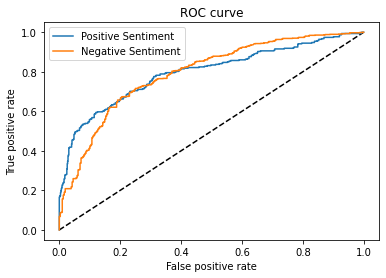

In [230]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [231]:
from sklearn.metrics import f1_score
predicted_labels = pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.402791
F1-macro = 0.310407


In [232]:
from sklearn.metrics import classification_report
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.906921  0.495437  0.640809       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.929825  0.172078  0.290411       308

    accuracy                       0.402791      1075
   macro avg   0.612249  0.222505  0.310407      1075
weighted avg   0.913483  0.402791  0.540416      1075



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ~ gCV + LogRegr ~

In [233]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')
gcv_lr = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2', 'elasticnet']},
    scoring=f1_macro_scorer,
    n_jobs=-1,
)

In [234]:
gcv_lr_tp1 = time.time()
gcv_lr.fit(X_transformed_and_selected, labels)
gcv_lr_tp2 = time.time()
print(f'Time needed for search: {gcv_lr_tp2 - gcv_lr_tp1}s')

Time needed for search: 6.456953048706055s


In [235]:
gcv_lr_bp = gcv_lr.best_params_
print(gcv_lr_bp)

{'C': 100.0, 'penalty': 'l2'}


In [236]:
bcls_gcv_lr = LogisticRegression(
                                 solver='liblinear', 
                                 verbose=True, 
                                 C=gcv_lr_bp['C'], 
                                 penalty=gcv_lr_bp['penalty']
                                )

In [237]:
gcv_lr_tp3 = time.time()
bcls_gcv_lr.fit(X_transformed_and_selected, labels)
gcv_lr_tp4 = time.time()
print(f'Time needed for computation: {gcv_lr_tp4 - gcv_lr_tp3}s')

[LibLinear]Time needed for computation: 0.18684124946594238s


In [238]:
best_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_gcv_lr)
    ]
)

In [239]:
probabilities = best_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

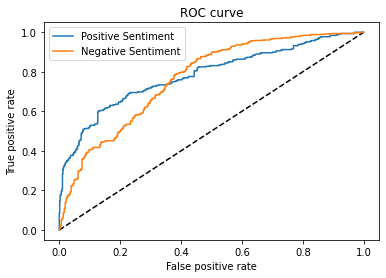

In [240]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [241]:
predicted_labels = best_pipeline_for_se.predict(texts_for_testing)
fmi_gcv_lr = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_gcv_lr = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_gcv_lr))
print('F1-macro = {0:.6f}'.format(fma_gcv_lr))

F1-micro = 0.510698
F1-macro = 0.390946


In [242]:
clsrep_gcv_lr = classification_report(labels_for_testing, predicted_labels, digits=6)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [243]:
print(clsrep_gcv_lr)

              precision    recall  f1-score   support

    negative   0.849524  0.581486  0.690402       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.865546  0.334416  0.482436       308

    accuracy                       0.510698      1075
   macro avg   0.571690  0.305301  0.390946      1075
weighted avg   0.854114  0.510698  0.630818      1075



# ~ rCV + LogReg ~

In [244]:
from sklearn.model_selection import RandomizedSearchCV

In [245]:
rcv_lr = RandomizedSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_distributions={
                'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    n_iter = 100,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [246]:
rcv_lr_tp1 = time.time()
rcv_lr.fit(X_transformed_and_selected, labels)
rcv_lr_tp2 = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [247]:
print(f'Time needed for search: {rcv_lr_tp2 - rcv_lr_tp1}s')
rcv_lr_bp = rcv_lr.best_params_
print(rcv_lr_bp)

Time needed for search: 5.524379253387451s
{'penalty': 'l2', 'C': 100.0}


In [248]:
bcls_rcv_lr = LogisticRegression(
                                 solver='liblinear', 
                                 verbose=True, 
                                 C=rcv_lr_bp['C'], 
                                 penalty=rcv_lr_bp['penalty']
                                 )
rcv_lr_tp3 = time.time()
bcls_rcv_lr.fit(X_transformed_and_selected, labels)
rcv_lr_tp4 = time.time()
print('Time needed for computations: ', rcv_lr_tp4 - rcv_lr_tp3)

[LibLinear]Time needed for computations:  0.18508005142211914


In [249]:
rand_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_rcv_lr)
    ]
)

In [250]:
probabilities = rand_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

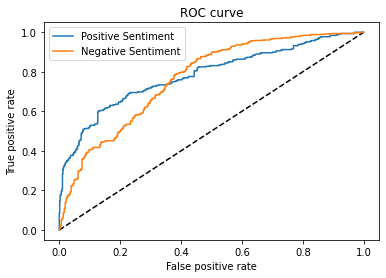

In [251]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [252]:
predicted_labels = rand_pipeline_for_se.predict(texts_for_testing)
fmi_rcv_lr = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_rcv_lr = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_rcv_lr))
print('F1-macro = {0:.6f}'.format(fma_rcv_lr))

F1-micro = 0.510698
F1-macro = 0.390946


In [253]:
clsrep_rcv_lr = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_rcv_lr)

              precision    recall  f1-score   support

    negative   0.849524  0.581486  0.690402       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.865546  0.334416  0.482436       308

    accuracy                       0.510698      1075
   macro avg   0.571690  0.305301  0.390946      1075
weighted avg   0.854114  0.510698  0.630818      1075



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ~ gCV + SGDC ~

In [254]:
from sklearn.linear_model import SGDClassifier

In [255]:
gcv_sgdc = GridSearchCV(
    estimator=SGDClassifier(loss='log'),
    param_grid={
                'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [256]:
gcv_sgdc_tp1 = time.time()
gcv_sgdc.fit(X_transformed_and_selected, labels)
gcv_sgdc_tp2 = time.time()

In [257]:
print(f'Time needed for search: {gcv_sgdc_tp2 - gcv_sgdc_tp1}s')
gcv_sgdc_bp = gcv_sgdc.best_params_
print(gcv_sgdc_bp)

Time needed for search: 3.900801658630371s
{'alpha': 0.0001, 'penalty': 'l1'}


In [258]:
bcls_gcv_sgdc = SGDClassifier( 
                     loss='log',
                     penalty=gcv_sgdc_bp['penalty'],
                     alpha=gcv_sgdc_bp['alpha'],
                     max_iter=1000
                    )

In [259]:
gcv_sgdc_tp3 = time.time()
bcls_gcv_sgdc.fit(X_transformed_and_selected, labels)
gcv_sgdc_tp4 = time.time()

In [260]:
print(f'Time needed for computations: {gcv_sgdc_tp4 - gcv_sgdc_tp3}s')

Time needed for computations: 0.07089710235595703s


In [261]:
sgdc_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_gcv_sgdc)
    ]
)

In [262]:
probabilities = sgdc_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

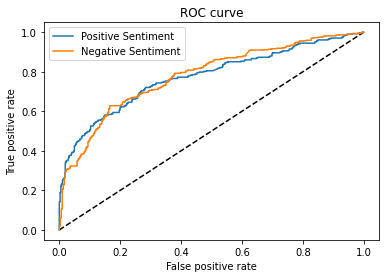

In [263]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [264]:
predicted_labels = sgdc_pipeline_for_se.predict(texts_for_testing)
fmi_gcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_gcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_gcv_sgdc))
print('F1-macro = {0:.6f}'.format(fma_gcv_sgdc))

F1-micro = 0.433488
F1-macro = 0.342033


In [265]:
clsrep_gcv_sgdc = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_gcv_sgdc)

              precision    recall  f1-score   support

    negative   0.895216  0.512386  0.651741       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.890244  0.237013  0.374359       308

    accuracy                       0.433488      1075
   macro avg   0.595153  0.249800  0.342033      1075
weighted avg   0.893792  0.433488  0.572268      1075



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ~ rCV + SGDClassifier ~

In [266]:
from sklearn.linear_model import SGDClassifier

In [267]:
rcv_sgdc = RandomizedSearchCV(
    estimator=SGDClassifier(loss='log'),
    param_distributions={
                'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    n_iter = 100,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [268]:
rcv_sgdc_tp1 = time.time()
rcv_sgdc.fit(X_transformed_and_selected, labels)
rcv_sgdc_tp2 = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [269]:
print(f'Time needed for search: {rcv_sgdc_tp2 - rcv_sgdc_tp1}s')
rcv_sgdc_bp = rcv_sgdc.best_params_
print(rcv_sgdc_bp)

Time needed for search: 3.885793447494507s
{'penalty': 'l1', 'alpha': 0.0001}


In [270]:
bcls_rcv_sgdc = SGDClassifier( 
                     loss='log',
                     penalty=rcv_sgdc_bp['penalty'],
                     alpha=rcv_sgdc_bp['alpha'],
                     max_iter=1000
                    )

In [271]:
rcv_sgdc_tp3 = time.time()
bcls_rcv_sgdc.fit(X_transformed_and_selected, labels)
rcv_sgdc_tp4 = time.time()

In [272]:
print(f'Time needed for computations: {rcv_sgdc_tp4 - rcv_sgdc_tp3}s')

Time needed for computations: 0.0656430721282959s


In [273]:
sgdc_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_rcv_sgdc)
    ]
)

In [274]:
probabilities = sgdc_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

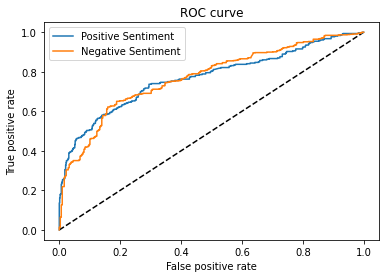

In [275]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [276]:
predicted_labels = sgdc_pipeline_for_se.predict(texts_for_testing)
fmi_rcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_rcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_rcv_sgdc))
print('F1-macro = {0:.6f}'.format(fma_rcv_sgdc))

F1-micro = 0.433488
F1-macro = 0.346718


In [277]:
clsrep_rcv_sgdc = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_rcv_sgdc)

              precision    recall  f1-score   support

    negative   0.898148  0.505867  0.647206       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.876404  0.253247  0.392947       308

    accuracy                       0.433488      1075
   macro avg   0.591518  0.253038  0.346718      1075
weighted avg   0.891918  0.433488  0.574358      1075



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ~ Выводы ~

In [278]:
scheme = '--- {}\nSearch time: {}\nComputation time: {}\nF1-micro = {}\nF1-macro = {}\nReport:\n{}\n' 
print(scheme.format('gCV + LogReg', gcv_lr_tp2-gcv_lr_tp1, gcv_lr_tp4-gcv_lr_tp3, fmi_gcv_lr, fma_gcv_lr, clsrep_gcv_lr))
print(scheme.format('rCV + LogReg', rcv_lr_tp2-rcv_lr_tp1, rcv_lr_tp4-rcv_lr_tp3, fmi_rcv_lr, fma_rcv_lr, clsrep_rcv_lr))
print(scheme.format('gCV + SGDC', gcv_sgdc_tp2-gcv_sgdc_tp1, gcv_sgdc_tp4-gcv_sgdc_tp3, fmi_gcv_sgdc, fma_gcv_sgdc, clsrep_gcv_sgdc))
print(scheme.format('rCV + SGDC', rcv_sgdc_tp2-rcv_sgdc_tp1, rcv_sgdc_tp4-rcv_sgdc_tp3, fmi_rcv_sgdc, fma_rcv_sgdc, clsrep_rcv_sgdc))

--- gCV + LogReg
Search time: 6.456953048706055
Computation time: 0.18684124946594238
F1-micro = 0.5106976744186047
F1-macro = 0.39094602465662714
Report:
              precision    recall  f1-score   support

    negative   0.849524  0.581486  0.690402       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.865546  0.334416  0.482436       308

    accuracy                       0.510698      1075
   macro avg   0.571690  0.305301  0.390946      1075
weighted avg   0.854114  0.510698  0.630818      1075


--- rCV + LogReg
Search time: 5.524379253387451
Computation time: 0.18508005142211914
F1-micro = 0.5106976744186047
F1-macro = 0.39094602465662714
Report:
              precision    recall  f1-score   support

    negative   0.849524  0.581486  0.690402       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.865546  0.334416  0.482436       308

    accuracy                       0.510698      1075
   macro avg   0.571690  0.305301  0